## Violations Search Tau

> Written by Jess Breda September 2023

For this notebook, I am working based on the to-dos from 2023-08-29 meeting and previous notebook `2023_08_violations_feature_analysis`/

The goals for this NB are

1. Update & test code to only apply exp filter to a session at a time

2. Update code to normalize all together before train test split. This might mean changing the order in generate_design_matrix. 
    * Or just a function that takes a list of dfs and finds the max value and normalize them by it?
    * Or just pass in the generated design matrix into train test split

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

In [2]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import DesignMatrixGenerator, ExpFilter
from get_rat_data import *
from multiclass_logistic_regression import MultiClassLogisticRegression
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Apply exp filter on session by session basis

In [5]:
# Example usage
df = pd.DataFrame(
    {
        "session": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "violation": np.random.randint(0, 2, 22),
    }
)
session_boundaries_mask = df["session"].diff() == 0

df["prev_violation"] = (df.violation.shift() * session_boundaries_mask).fillna(0)

tau = 3
filter_obj = ExpFilter(tau=tau, column="prev_violation")
filter_obj.apply_filter_to_dataframe(df)

Exp filter added for session 1 | Column: prev_violation, Tau: 3
Exp filter added for session 2 | Column: prev_violation, Tau: 3
Exp filter added for session 3 | Column: prev_violation, Tau: 3


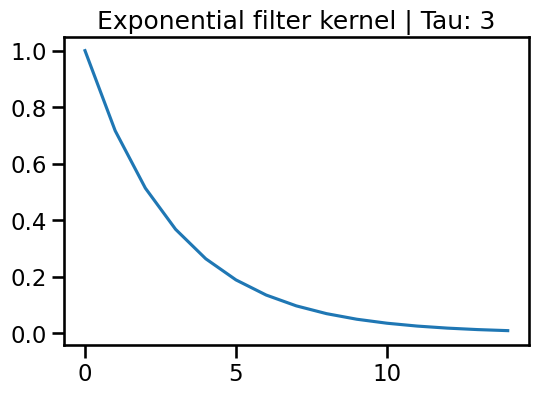

In [6]:
filter_obj.plot_kernel()

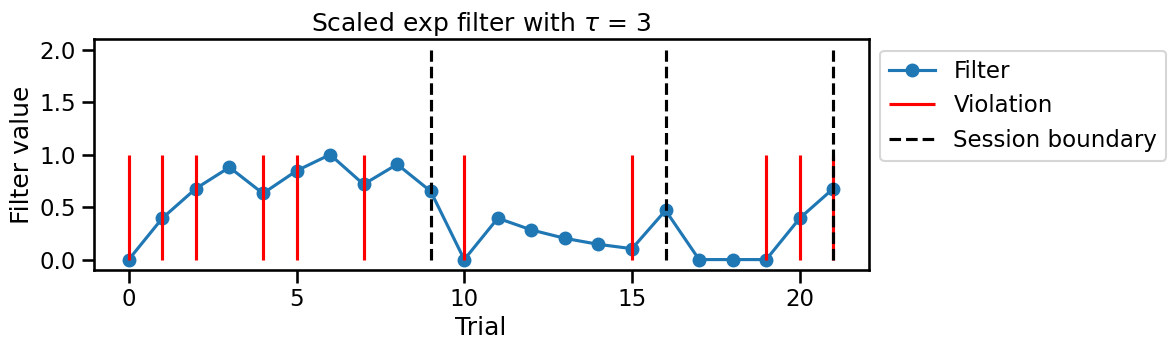

In [7]:
plot_kernel_validation(df, f"prev_violation_exp_{tau}")

TODO: 

[ ] write plot_feature_weights(animal_id, model_name)

[ ] add .plot_feature_weights

[ ] make trained/not df



In [270]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np


class SigmaTauSearchExperiment:
    def __init__(self, params):
        self.animals = params["animals"]
        self.sigmas = params["sigmas"]
        self.taus = params["taus"]
        self.model_names = self.generate_model_names(params)
        self.random_state = params["random_state"]
        self.test_size = params["test_size"]
        self.df = get_rat_viol_data(animal_ids=self.animals)
        self.stored_fits = []

    def run(self):
        for animal in self.animals:
            print(f"evaluating animal {animal}")
            if self.df.animal_id.nunique() > 1:
                # Load in data for specific animal
                animal_df = self.df.query("animal_id == @animal and training_stage > 2")
            else:
                animal_df = self.df.query("training_stage > 2")

            # Create a DesignMatrixGenerator object & get train/test sessions for animal
            dmg = DesignMatrixGenerator(verbose=False)
            dmg.get_train_test_sessions(
                animal_df, test_size=self.test_size, random_state=self.random_state
            )

            # Iterate over sigma/tau combinations
            for sigma in self.sigmas:
                for idx, tau in enumerate(self.taus):
                    # Generate design matrix & create train/test splits
                    X, Y = dmg.generate_design_matrix(
                        self.df,
                        tau=tau,
                        filter_column="prev_violation",
                        return_labels=True,
                    )
                    (
                        X_train,
                        X_test,
                        Y_train,
                        Y_test,
                    ) = dmg.apply_session_train_test_split(X, Y)

                    # Fit model & evaluate
                    model = MultiClassLogisticRegression(sigma=sigma)
                    W_fit = model.fit(X_train, Y_train)
                    nll = model.eval(X_test, Y_test)

                    # Store results
                    self.store(
                        animal, self.model_names[idx], nll, sigma, tau, X_test, W_fit
                    )

        self.results = pd.concat(self.stored_fits, ignore_index=True)
        return self.results

    def store(self, animal, model_name, nll, sigma, tau, X, W_fit):
        # Create a DataFrame for this iteration
        iter_df = pd.DataFrame(
            {
                "animal_id": [animal],
                "model_name": [model_name],
                "nll": [nll],
                "sigma": [sigma],
                "tau": [tau],
                "features": [list(X.columns)],
                "weights": [list(W_fit)],  # Convert numpy array to list
            }
        )
        # Append to the list of stored fits
        self.stored_fits.append(iter_df)

    @staticmethod
    def generate_model_names(params):
        taus = params["taus"]
        names = []

        for tau in taus:
            if tau is None:
                names.append("base")
            else:
                name = "t_" + str(tau)
                names.append(name)

        return names

    def find_best_fit(self, group="tau"):
        # if group is tau, will find the best sigma for
        # each tau tested.
        # if group is sigma, will find the best tau for
        # each sigma tested.

        best_fit_dfs = []

        for animal_id, sub_df in self.results.groupby(["animal_id"]):
            best_idx = sub_df.groupby(group)["nll"].idxmin()
            best_fit_df = sub_df.loc[best_idx][
                ["animal_id", "model_name", "sigma", "tau", "nll"]
            ]
            best_fit_dfs.append(best_fit_df)

        return pd.concat(best_fit_dfs, ignore_index=True)

    def plot_nll_over_taus(self, df=None):
        if df is None:
            df = self.find_best_fit(group="tau")

        n_animals = best_sigma_df.animal_id.nunique()
        fig, ax = plt.subplots(
            n_animals, 1, figsize=(15, 5 * n_animals), sharex=True, sharey=True
        )

        df["is_min"] = df.groupby("animal_id")["nll"].transform(lambda x: x == x.min())

        if n_animals == 1:
            ax = [ax]

        for idx, (animal_id, sub_df) in enumerate(df.groupby("animal_id")):
            plt.xticks(rotation=90)

            current_ax = ax[idx] if n_animals > 1 else ax[0]

            sns.pointplot(
                x="model_name",
                y="nll",
                data=sub_df,
                ax=current_ax,
                order=experiment.model_names,
                hue="is_min",
                palette=["grey", "red"],
                join=False,
            )

            # aesthetics
            plt.xticks(rotation=90)
            sns.despine()
            current_ax.legend().remove()
            current_ax.set(
                ylabel="Test NLL",
                title=f"Animal {df.animal_id.unique()[0]}",
            )
            # if on the last plot, add the x-axis label
            if idx == n_animals - 1:
                current_ax.set(xlabel="Model")
            else:
                current_ax.set(xlabel="")

        return None

    def create_pivot_for_tau_heatmap(self, df=None):
        if df is None:
            df = self.find_best_fit(group="tau")

        pivot = df.pivot(index="animal_id", columns="model_name", values="nll")

        # reorder the df to match the order of the model names
        # e.g. so that t_10 doesn't come before t_5

        columns_with_numbers = [
            col for col in pivot.columns if "_" in col and col.split("_")[-1].isdigit()
        ]
        columns_without_numbers = [
            col for col in pivot.columns if col not in columns_with_numbers
        ]

        # Sort both lists
        columns_with_numbers.sort(key=lambda x: int(x.split("_")[-1]))
        columns_without_numbers.sort()

        # Combine the lists
        sorted_columns = columns_without_numbers + columns_with_numbers

        # Reorder the DataFrame based on the sorted column names
        pivot = pivot[sorted_columns]

        return pivot

    def plot_tau_heatmap(self, df=None, vmin=10000, vmax=20000, cmap="Blues"):
        if df is None:
            df = self.create_pivot_for_tau_heatmap()

        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(df, annot=True, cmap=cmap, fmt=".2e", ax=ax, vmin=vmin, vmax=vmax)

        plt.title("NLL by Animal ID and Model")
        plt.xlabel("Model")
        plt.ylabel("Animal ID")

        yticks = ax.get_yticks()
        xticks = ax.get_xticks()

        for i, (index, row) in enumerate(df.iterrows()):
            min_val_col = row.idxmin()
            min_val_idx = df.columns.tolist().index(min_val_col)

            y_coord = yticks[i] - 0.5
            x_coord = xticks[min_val_idx] - 0.5

            rect = patches.Rectangle(
                (x_coord, y_coord),
                1,
                1,
                linewidth=3,
                edgecolor="White",
                facecolor="none",
            )

            ax.add_patch(rect)

        return None

    def plot_best_sigma_tau_by_animal(self, jitter=0.025, df=None):
        # TODO could add hue as a param to color by trained/not trained"

        if df is None:
            df = self.find_best_fit(group=["animal_id"])

        fig, ax = plt.subplots(figsize=(10, 8))

        # jitter points so animals don't overlap
        df["tau"] = df["tau"] + np.random.uniform(-jitter, jitter, len(df))
        df["sigma"] = df["sigma"] + np.random.uniform(-jitter, jitter, len(df))

        ax.grid()
        sns.scatterplot(data=df, x="tau", y="sigma", hue="animal_id", ax=ax)

        # aesthetics
        ymin = self.results.sigma.min() - 0.5
        ymax = self.results.sigma.max() + 0.5
        xmin = self.results.tau.min() - 0.5
        xmax = self.results.tau.max() + 0.5

        ax.set(
            xlim=(xmin, xmax),
            ylim=(ymin, ymax),
            xlabel="Tau",
            ylabel="Sigma",
            title="Best Fit Parameters",
        )

        return None

In [275]:
params = {
    "animals": ["W065", "W078"],
    "sigmas": [0, 0.1],  # 0.3, 0.5],  # 0.7, 1, 1.5, 3, 5],
    "taus": [0, 1, 2, 10],  # 3, 5, 7, 9, 12, 15, 18, 20, 25, 30],
    "random_state": 44,
    "test_size": 0.25,
}

experiment = SigmaTauSearchExperiment(params)
results = experiment.run()

returning data for ['W065', 'W078']
evaluating animal W065
         Current function value: 56950.439338
         Iterations: 26
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 56343.143893
         Iterations: 26
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 56063.155681
         Iterations: 25
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 56615.096004
         Iterations: 25
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 57102.208191
         Iterations: 29
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 56566.220503
         Iterations: 28
         Function evaluations

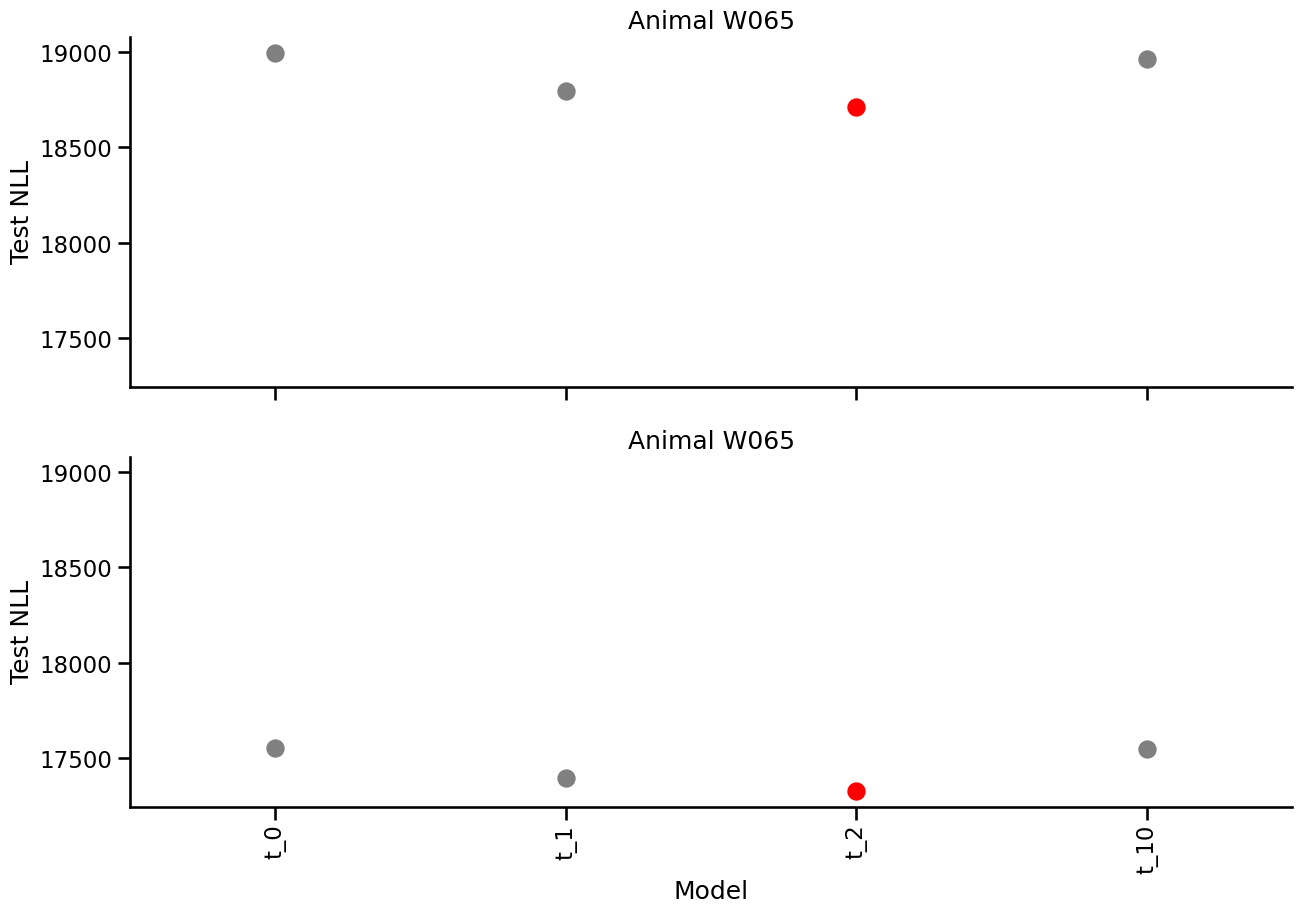

In [276]:
experiment.plot_nll_over_taus()

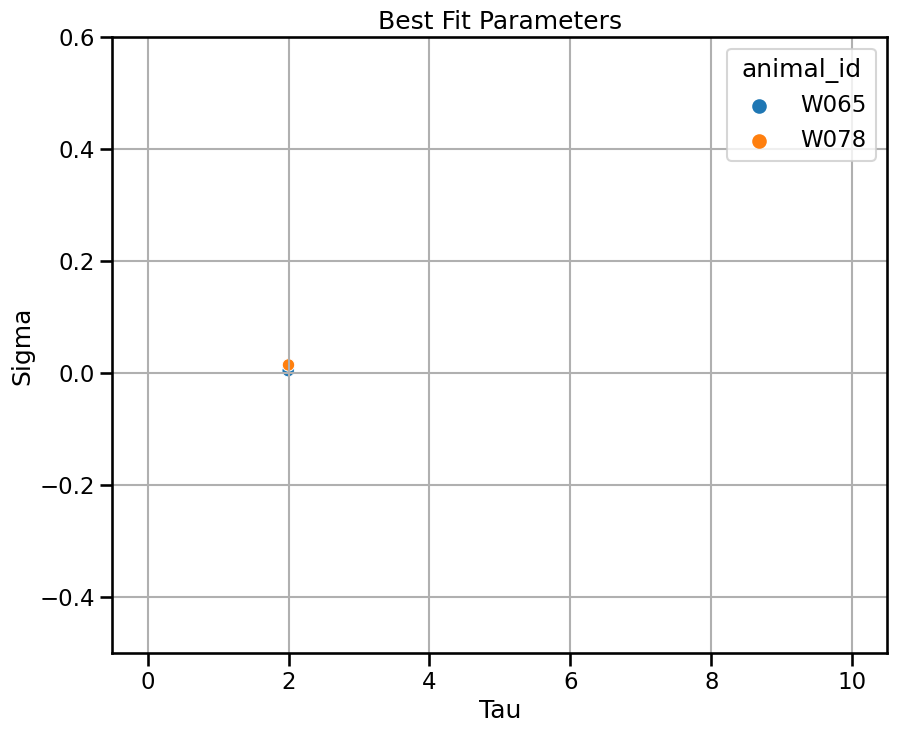

In [277]:
experiment.plot_best_sigma_tau_by_animal(jitter=0.025)

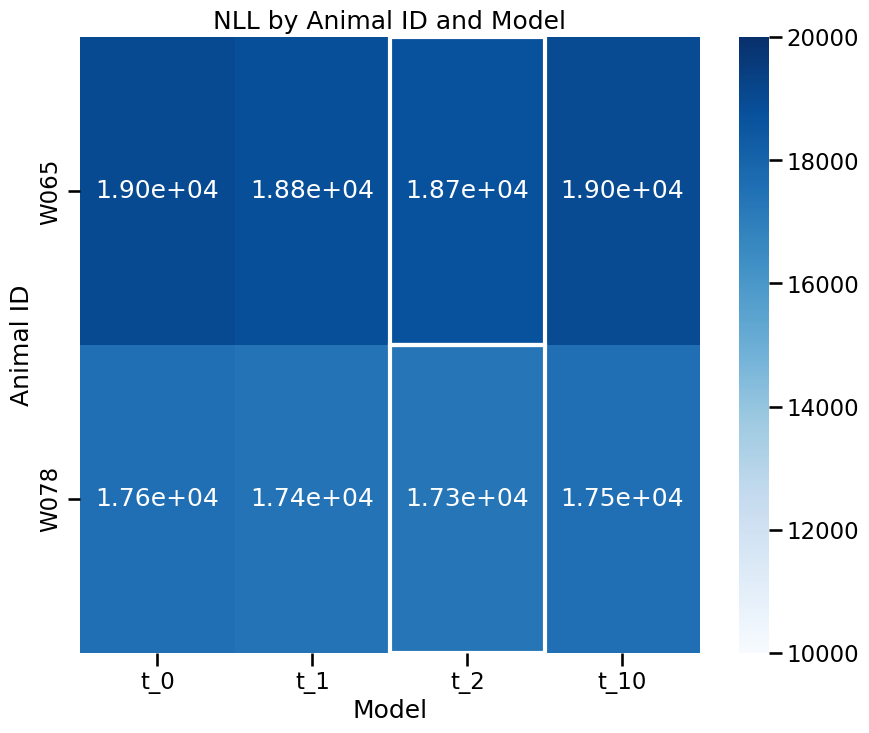

In [278]:
experiment.plot_tau_heatmap()

In [247]:
def plot_best_sigma_tau_by_animal(self, jitter=0.1, df=None):
    if df is None:
        df = self.find_best_fit(group=["animal_id"])

    fig, ax = plt.subplots(figsize=(10, 8))

    # jitter points so animals don't overlap
    df["tau"] = df["tau"] + np.random.uniform(-jitter, jitter, len(df))
    df["sigma"] = df["sigma"] + np.random.uniform(-jitter, jitter, len(df))

    sns.scatterplot(data=df, x="tau", y="sigma", hue="animal_id", ax=ax)

    ymin = self.results.sigma.min() - 0.5
    ymax = self.results.sigma.max() + 0.5
    xmin = self.results.tau.min() - 0.5
    xmax = self.results.tau.max() + 0.5

    ax.set(
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        xlabel="Tau",
        ylabel="Sigma",
        title="Best Fit Parameters",
    )

    ax.grid()

    return None

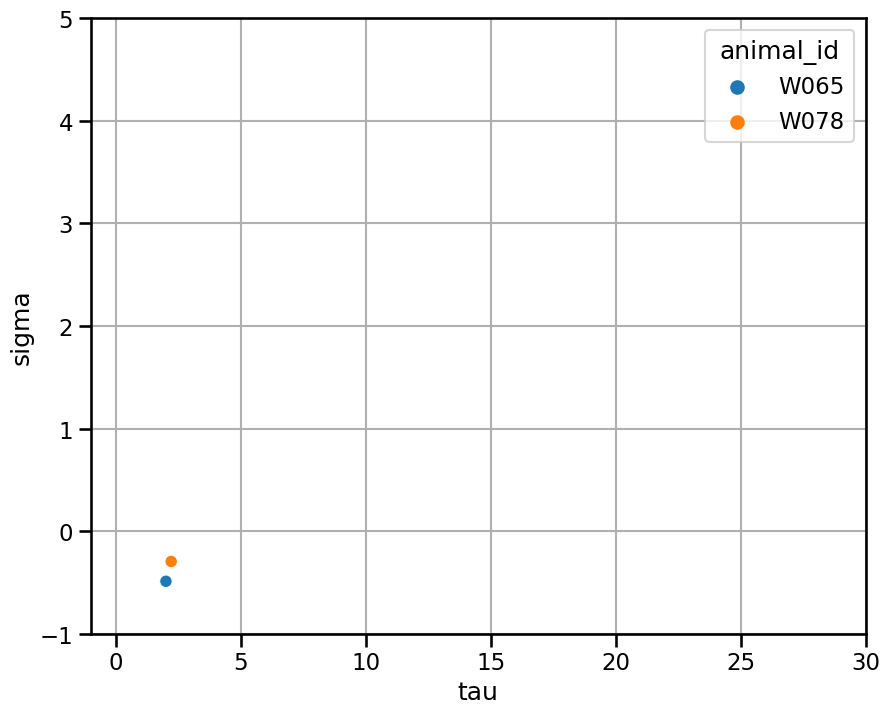

In [246]:
fig, ax = plt.subplots(figsize=(10, 8))
jitter_value = 0.1  # Set the amount of jitter
cols = ["tau", "sigma"]
dff["tau"] = dff["tau"] + np.random.uniform(-jitter_value, jitter_value, len(dff))
dff["sigma"] = dff["sigma"] + np.random.uniform(-jitter_value, jitter_value, len(dff))


sns.scatterplot(x="tau", y="sigma", data=dff, hue="animal_id", ax=ax)

ax.set(xlim=(-1, 30), ylim=(-1, 5))

ax.grid()

In [239]:
dff[cols]

,tau,sigma
0,1.852082,-0.399557
1,1.852082,-0.399557


In [211]:
sub_df = results[["animal_id", "model_name", "sigma", "tau", "nll"]]

In [191]:
experiment.find_best_fit(mode="tau")

,animal_id,model_name,sigma,nll
0,W065,t_2,0.0,18713.426680
1,W065,t_2,0.1,18725.347439
2,W078,t_2,0.0,17330.006916
3,W078,t_2,0.1,17347.024292


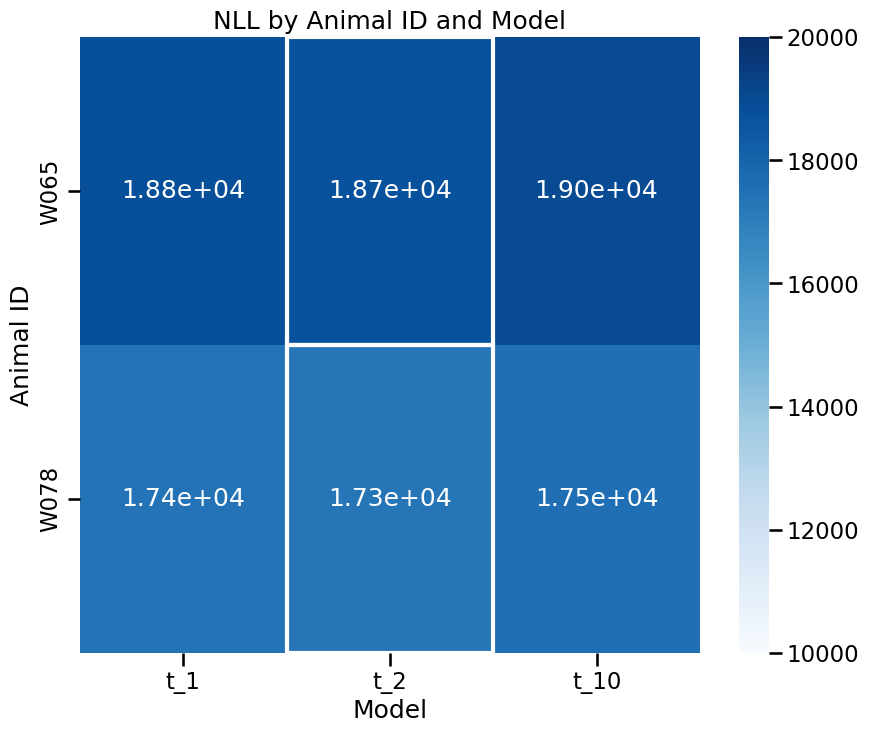

In [227]:
experiment.plot_tau_heatmap()

In [133]:
reshaped_df
# Separate the columns into those that contain numbers and those that do not
columns_with_numbers = [
    col for col in reshaped_df.columns if "_" in col and col.split("_")[-1].isdigit()
]
columns_without_numbers = [
    col for col in reshaped_df.columns if col not in columns_with_numbers
]

# Sort both lists
columns_with_numbers.sort(key=lambda x: int(x.split("_")[-1]))
columns_without_numbers.sort()

# Combine the lists
sorted_columns = columns_without_numbers + columns_with_numbers

# Reorder the DataFrame based on the sorted column names
reshaped_df = reshaped_df[sorted_columns]

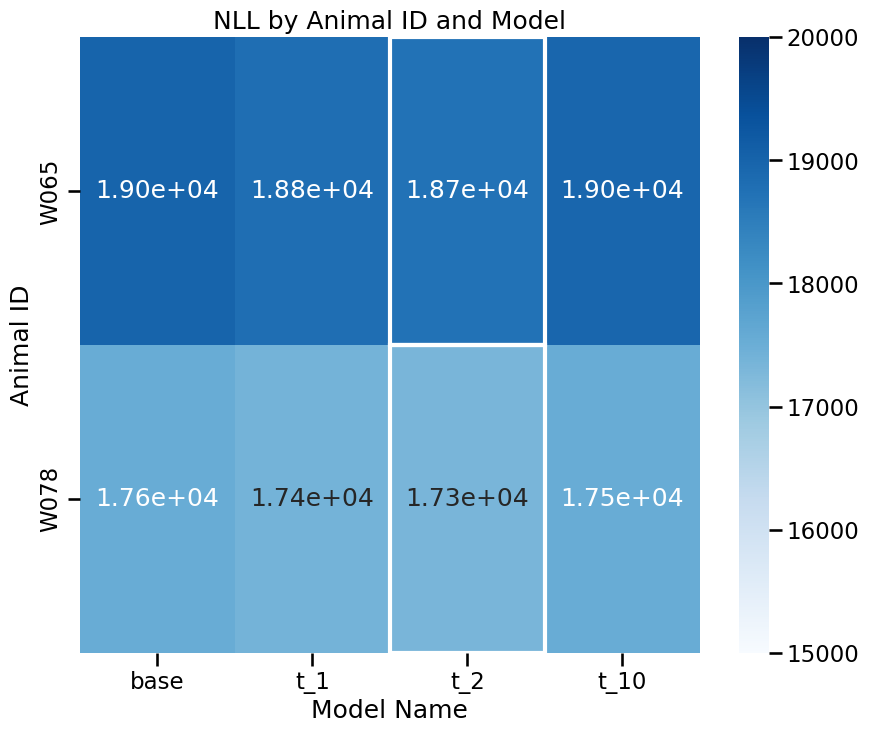

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the reshaped DataFrame using pivot

reshaped_df = create_df_for_heatmap(best_sigma_df, mode="tau")

# Create the heatmap using Seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    reshaped_df, annot=True, cmap="Blues", fmt=".2e", ax=ax, vmin=15000, vmax=20000
)

plt.title("NLL by Animal ID and Model")
plt.xlabel("Model Name")
plt.ylabel("Animal ID")

# Retrieve the y-ticks and x-ticks from the axis object
yticks = ax.get_yticks()
xticks = ax.get_xticks()

# Loop through each row to find the column with the minimum value and add a rectangle around it
for i, (index, row) in enumerate(reshaped_df.iterrows()):
    min_val_col = row.idxmin()
    min_val_idx = reshaped_df.columns.tolist().index(min_val_col)

    y_coord = yticks[i] - 0.5  # Adjusting by -0.5 for precise alignment
    x_coord = xticks[min_val_idx] - 0.5  # Adjusting by -0.5 for precise alignment

    rect = patches.Rectangle(
        (x_coord, y_coord), 1, 1, linewidth=3, edgecolor="White", facecolor="none"
    )

    ax.add_patch(rect)

plt.show()

In [228]:
def plot_class_weights(feature_names, W_fit, title=""):
    """
    Plot the weights for each feature and class as bar charts.

    Parameters:
    feature_names: list (D)
         column names from design matrix that related
         to features in W_fit
    W_fit : np.ndarray (D x C)
        weights obtained after optimization (D x C)
    title : str (default: "")
        title for the plot
    """

    # Extract shape details
    D, C = W_fit.shape
    classes = ["L", "R", "V"]

    # Prepare data for Seaborn
    weight_data = []
    for c in range(C):
        for d in range(D):
            weight_data.append(
                {
                    "Weight": W_fit[d, c],
                    "Feature": feature_names[d],
                    "Class": classes[c],
                }
            )

    df_weights = pd.DataFrame(weight_data)

    # Plot using Seaborn
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.axhline(y=0, color="black")
    sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights, ax=ax)
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.title(title)

    return None


def plot_class_weights_from_df(fitting_info_df, model_name):
    row = fitting_info_df.loc[fitting_info_df["model_name"] == model_name].iloc[0]
    features = row["features"]
    weights = np.array(row["weights"])
    plot_class_weights(features, weights, title=model_name)

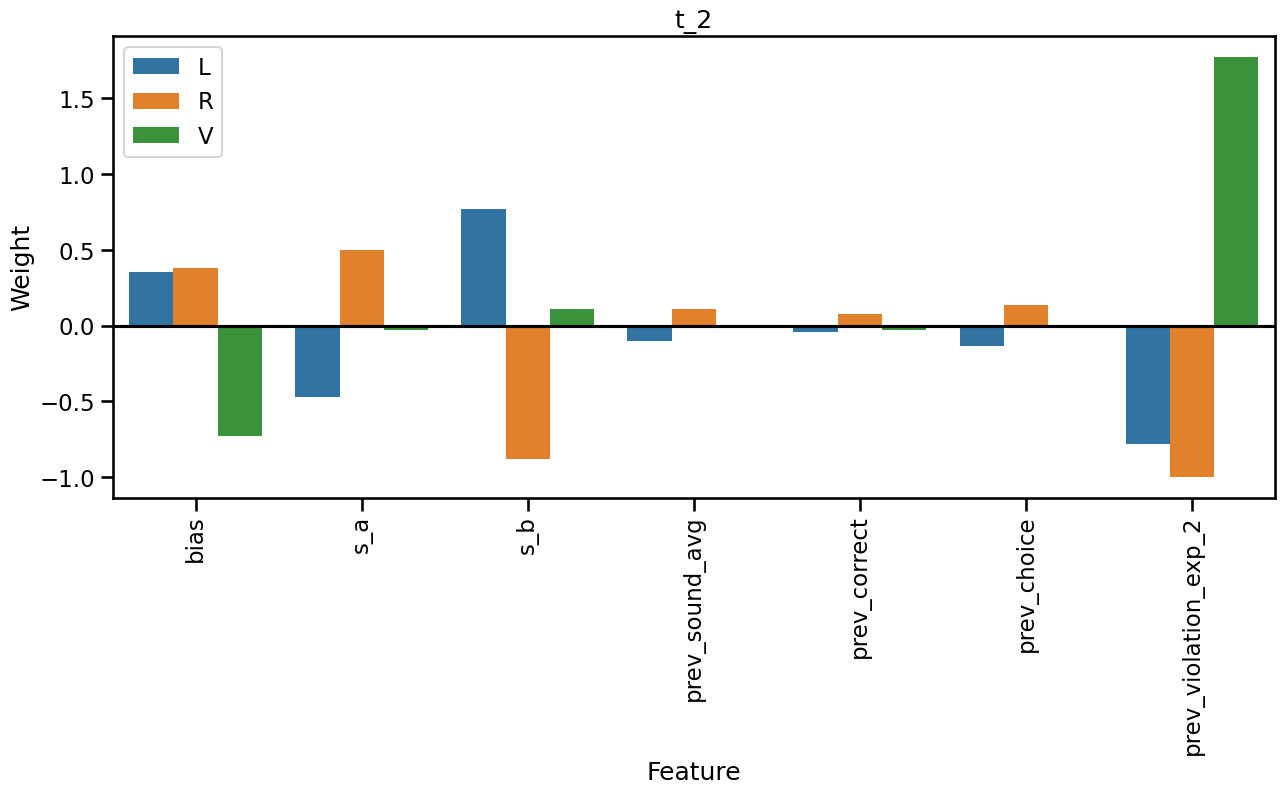

In [237]:
plot_class_weights_from_df(fitting_info_df, "t_2")

Could think about putting some of the plotting functions above into a separate file. 

Also could involve some polishing where FitMutliClassLR class could be made with .fit, .eval, .store .plot(?) functions. 
